# Radial Velocity Analysis

Since we now have extracted the spectrum from each of the science frame, we want to find the position of the spectral lines in each of the spectrum in order to compute the radial velocities.

## Position of Spectral features

We now want to find the position of the prominent spectral features in the flat corrected spectrum. The idea is to fit the Gaussian to the spectral line and thus finding the position of the line. That is a tricky procedure in the sense that, we first want to specify the location of the spectral line manually and then extract the data for only that region, and finally fitting Gaussian to that data. To make this process a little bit simpler we wrote a python script that uses the `SpanSelector` function from `matplotlib.widgets` to let user specify the location of as many lines user wants and fit Gaussian to each of them. Later, this script would save the position of each of the lines (in pixel space though) in sperate file. That file would have position of specified lines in each of the frames. Below, we can use this information to plot the position of line with time.

In the following figure, you would see the position of the four of the lines in each frames.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy.io import fits
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
import os
import utils as utl

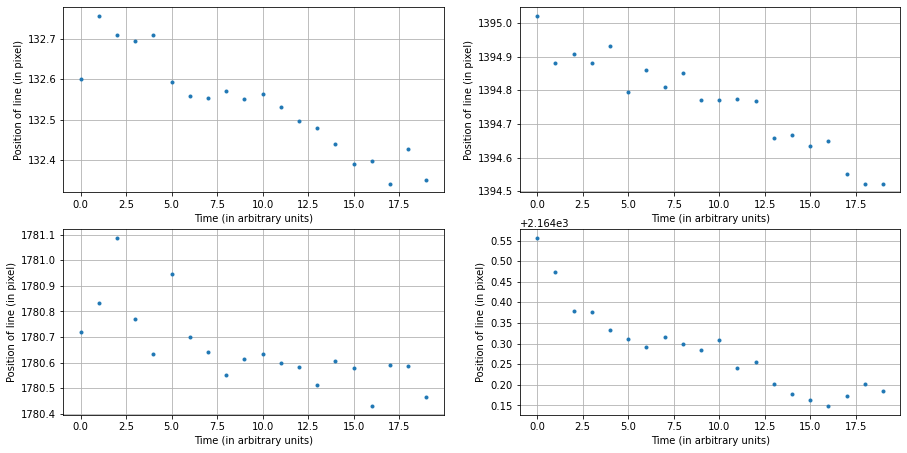

In [2]:
pos1, pos2, pos3, pos4 = np.loadtxt(os.getcwd() + '/Results/positions_2.dat', usecols=(0,1,2,3), unpack=True)

lin1 = np.sort(pos1)
lin2 = np.sort(pos2)

fig0, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 7.5))
axs[0,0].errorbar(np.arange(len(pos1)), pos1, fmt='.')
axs[0,0].set_xlabel('Time (in arbitrary units)')
axs[0,0].set_ylabel('Position of line (in pixel)')
axs[0,0].grid()
axs[0,1].errorbar(np.arange(len(pos2)), pos2, fmt='.')
axs[0,1].set_xlabel('Time (in arbitrary units)')
axs[0,1].set_ylabel('Position of line (in pixel)')
axs[0,1].grid()
axs[1,0].errorbar(np.arange(len(pos3)), pos3, fmt='.')
axs[1,0].set_xlabel('Time (in arbitrary units)')
axs[1,0].set_ylabel('Position of line (in pixel)')
axs[1,0].grid()
axs[1,1].errorbar(np.arange(len(pos4)), pos4, fmt='.')
axs[1,1].set_xlabel('Time (in arbitrary units)')
axs[1,1].set_ylabel('Position of line (in pixel)')
axs[1,1].grid()